_________________

# Imports

Import all relevant dependencies
_________________

In [1]:
import torch
from utils import download_MNIST, convert_data_to_01, plot_digits, plot_original_vs_encoded

from models.autoencoder.autoencoder import  Autoencoder
from models.autoencoder.autoencoder_utils import train_autoencoder
from models.ebm.energy_net import EnergyNet
from models.ebm.energy_net_utils import langevin_MCMC, evaluate_ebm_model, train_ebm

import torch

import matplotlib.pyplot as plt


_________________

# Dataset
--- Download MNIST is not already present <br>
--- Convert to 0-1 binary according to a given threshold <br>
--- Prepare Train-Test dataset <br>
--- Plot a few images <br>
_________________

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3883583.89it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 136739.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1166102.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3308532.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

The binary data is stored at ::: ./data/MNIST_binary/
The binary data is stored at ::: ./data/MNIST_binary/


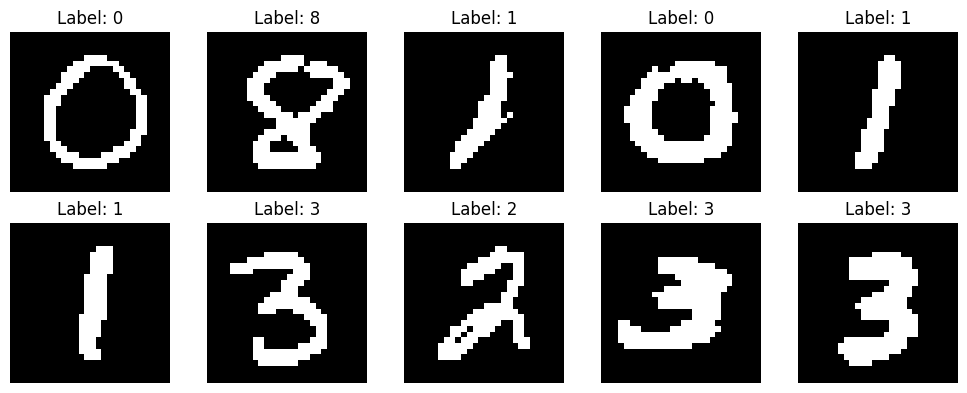

In [2]:
# Download MNIST Dataset
train_dataset, test_dataset = download_MNIST()

# Convert Dataset to 0/1 binary
convert_data_to_01(dataset=train_dataset, threshold=100, kind='train')
convert_data_to_01(dataset=test_dataset,  threshold=100, kind='test')

# Load 0/1 binary dataset
X_train  = torch.load('./data/MNIST_binary/X_train.pt').to(torch.float32) 
X_test   = torch.load('./data/MNIST_binary/X_test.pt').to(torch.float32)
Y_train, Y_test = torch.load('./data/MNIST_binary/Y_train.pt'), torch.load('./data/MNIST_binary/Y_test.pt')

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualise digits
plot_digits(X=X_test, Y=Y_test, n=10)

_________________________
# Autoencoder : Training

Firstly we will train an encoder-decoder architecture do that MCMC samplinf can be eeffectively applied in the continuos domain.
_________________________


In [4]:
# Load Autoencoder
autoencoder = Autoencoder(input_dim=28*28, hidden_dim=1024, encoded_dim=4)
autoencoder.to(device)

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=4, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=1024, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): GELU(approximate='none')
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [5]:
# Train Autoencoder
train_autoencoder(model=autoencoder, X_train=X_train, X_test=X_test, 
                 lr=3e-4, num_epochs=30, batch_size=64, device=device)


MODEL NAME : autoencoder_10-06-2024_16:24:57
BEST MODEL @ EPOCH : [1/30]
Epoch [1/30]  |  Train Loss: 0.048507  |  Test Loss: 0.047490
BEST MODEL @ EPOCH : [2/30]
Epoch [2/30]  |  Train Loss: 0.042323  |  Test Loss: 0.044179
BEST MODEL @ EPOCH : [3/30]
Epoch [3/30]  |  Train Loss: 0.045079  |  Test Loss: 0.042805
BEST MODEL @ EPOCH : [4/30]
Epoch [4/30]  |  Train Loss: 0.046509  |  Test Loss: 0.041660
BEST MODEL @ EPOCH : [5/30]
Epoch [5/30]  |  Train Loss: 0.046425  |  Test Loss: 0.040867
BEST MODEL @ EPOCH : [6/30]
Epoch [6/30]  |  Train Loss: 0.041182  |  Test Loss: 0.040321
BEST MODEL @ EPOCH : [7/30]
Epoch [7/30]  |  Train Loss: 0.038173  |  Test Loss: 0.039897
BEST MODEL @ EPOCH : [8/30]
Epoch [8/30]  |  Train Loss: 0.032416  |  Test Loss: 0.039389
BEST MODEL @ EPOCH : [9/30]
Epoch [9/30]  |  Train Loss: 0.039696  |  Test Loss: 0.039340
BEST MODEL @ EPOCH : [10/30]
Epoch [10/30]  |  Train Loss: 0.037124  |  Test Loss: 0.039033
BEST MODEL @ EPOCH : [11/30]
Epoch [11/30]  |  Train

____________

Once the model is trained, we can see the results of the trained 
____________

In [6]:
print(f"The model is saved at : {autoencoder.ckpt_path}")
autoencoder.load_pretrained_model(autoencoder.ckpt_path)

The model is saved at : ./saved_ckpts/autoencoder/autoencoder_10-06-2024_16:24:57.pth
Model Loaded Sucessully


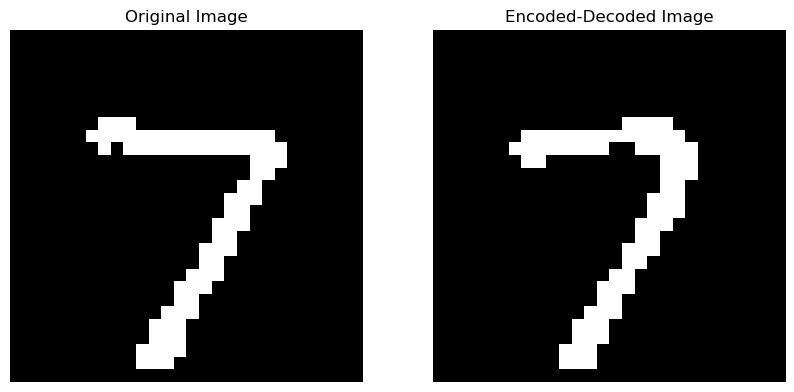

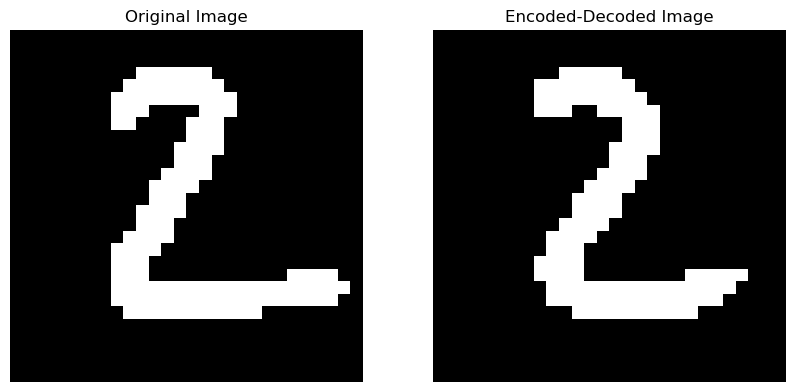

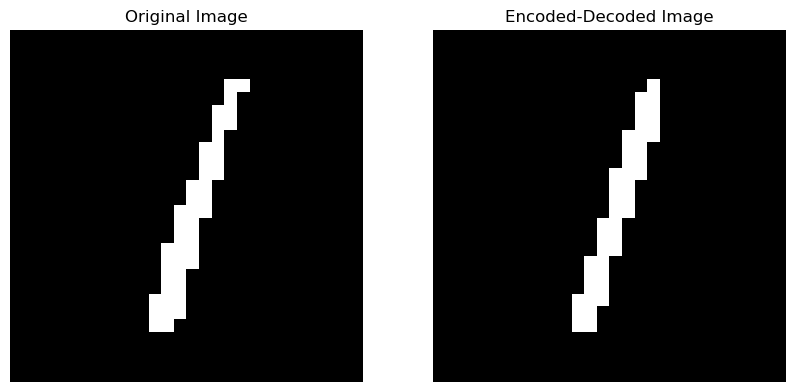

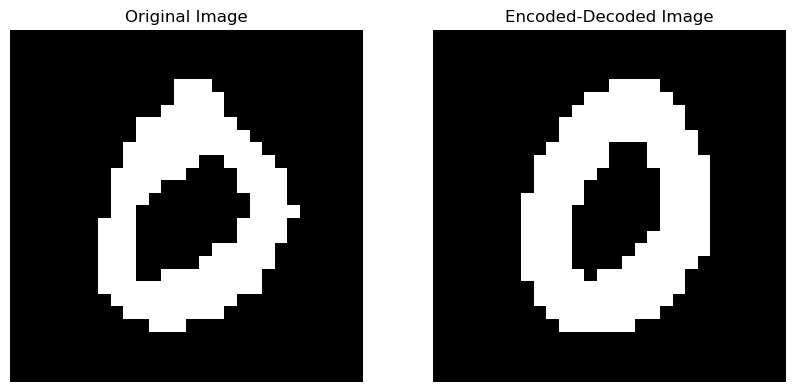

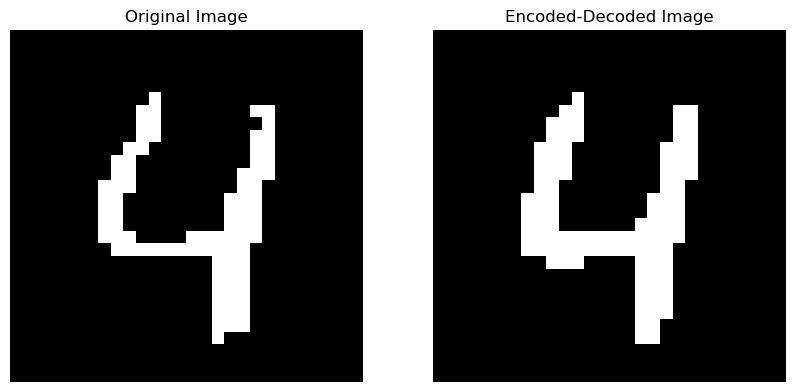

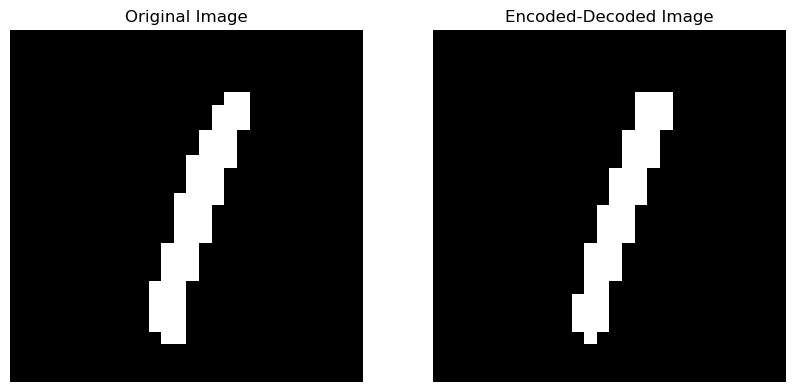

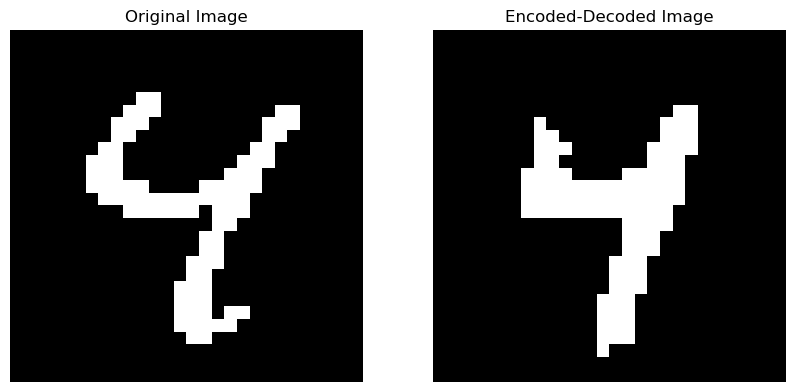

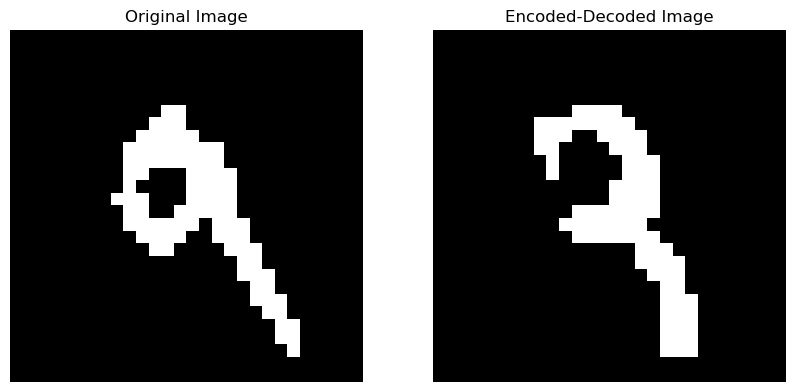

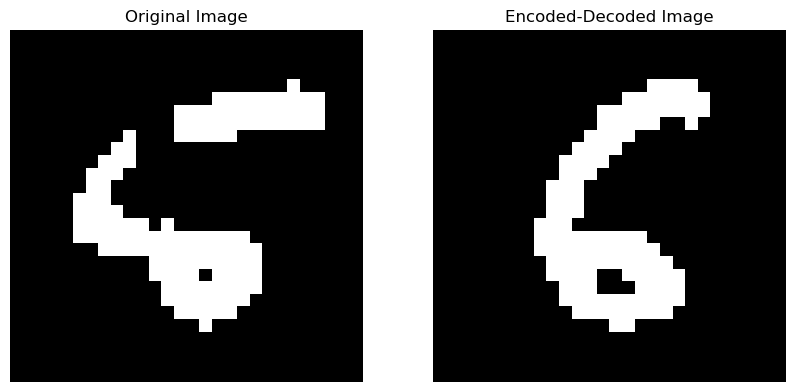

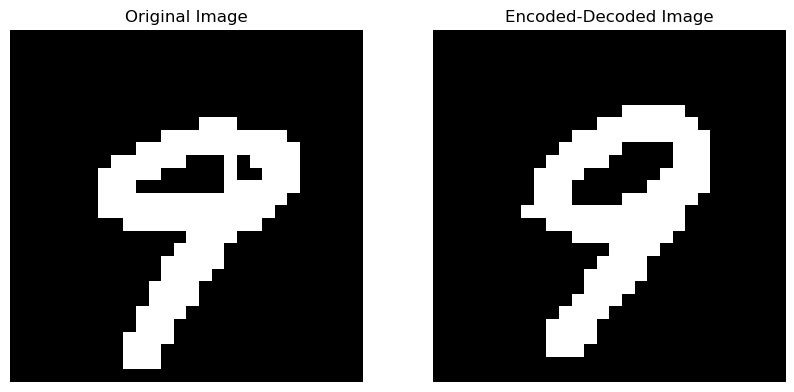

In [7]:
for idx in range(10):
    plot_original_vs_encoded(x=X_test[idx], model=autoencoder)

______________________________

# EBM
Once the autoencoder is trained we can now, train the EBM where the inputs come from the encoder of the above trained AutoEncoder
______________________________



In [8]:
energy_model = EnergyNet(in_dim=autoencoder.encoded_dim, autoencoder_ckpt_path=autoencoder.ckpt_path ,hid_dim=8)
energy_model.to(device)

EnergyNet(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [9]:
# Train EBM
# Note that for training only 4096 of the total points are used as it takes a lot of time to train
# However in the notebook inference.ipynb, the best model is loaded that is trained on all data.

train_ebm(energy_model=energy_model, autoencoder=autoencoder, X_train=X_train[:4096], X_test=X_test, 
          device=device, batch_size=1024, mcmc_samples_per_datapoint=8, num_epochs=3, lr=3e-4)


MODEL NAME : ebm_10-06-2024_16:25:58
############# EPOCH 1 STARTED TRAINING #############

	BATCH : 1 |  TOTAL BATCH LOSS: 0.12881842
	BATCH : 2 |  TOTAL BATCH LOSS: 0.12877911
	BATCH : 3 |  TOTAL BATCH LOSS: 0.13391644
	BATCH : 4 |  TOTAL BATCH LOSS: 0.12255577

	EPOCH COMPLETE | TOTAL EPOCH LOSS 0.12851744

	BEST MODEL @ EPOCH : [1/3]
############# EPOCH 2 STARTED TRAINING #############

	BATCH : 1 |  TOTAL BATCH LOSS: 0.13338882
	BATCH : 2 |  TOTAL BATCH LOSS: 0.12464191
	BATCH : 3 |  TOTAL BATCH LOSS: 0.12607718
	BATCH : 4 |  TOTAL BATCH LOSS: 0.11731173

	EPOCH COMPLETE | TOTAL EPOCH LOSS 0.12535491

	BEST MODEL @ EPOCH : [2/3]
############# EPOCH 3 STARTED TRAINING #############

	BATCH : 1 |  TOTAL BATCH LOSS: 0.11639637
	BATCH : 2 |  TOTAL BATCH LOSS: 0.12422355
	BATCH : 3 |  TOTAL BATCH LOSS: 0.10529877
	BATCH : 4 |  TOTAL BATCH LOSS: 0.10502429

	EPOCH COMPLETE | TOTAL EPOCH LOSS 0.11273574

	BEST MODEL @ EPOCH : [3/3]


_______________________

# Final inference 
_______________________


In [10]:
# Load the trained model
print(f"The Energy model is saved at : {energy_model.ebm_ckpt_path}")
energy_model.load_pretrained_model(energy_model.ebm_ckpt_path)

The Energy model is saved at : ./saved_ckpts/ebm/ebm_10-06-2024_16:25:58.pth
Model Loaded Sucessully


In [12]:
# Generate images from energy model
generated_images  = energy_model.generate_images(autoencoder=autoencoder, num_images=25, device=device)

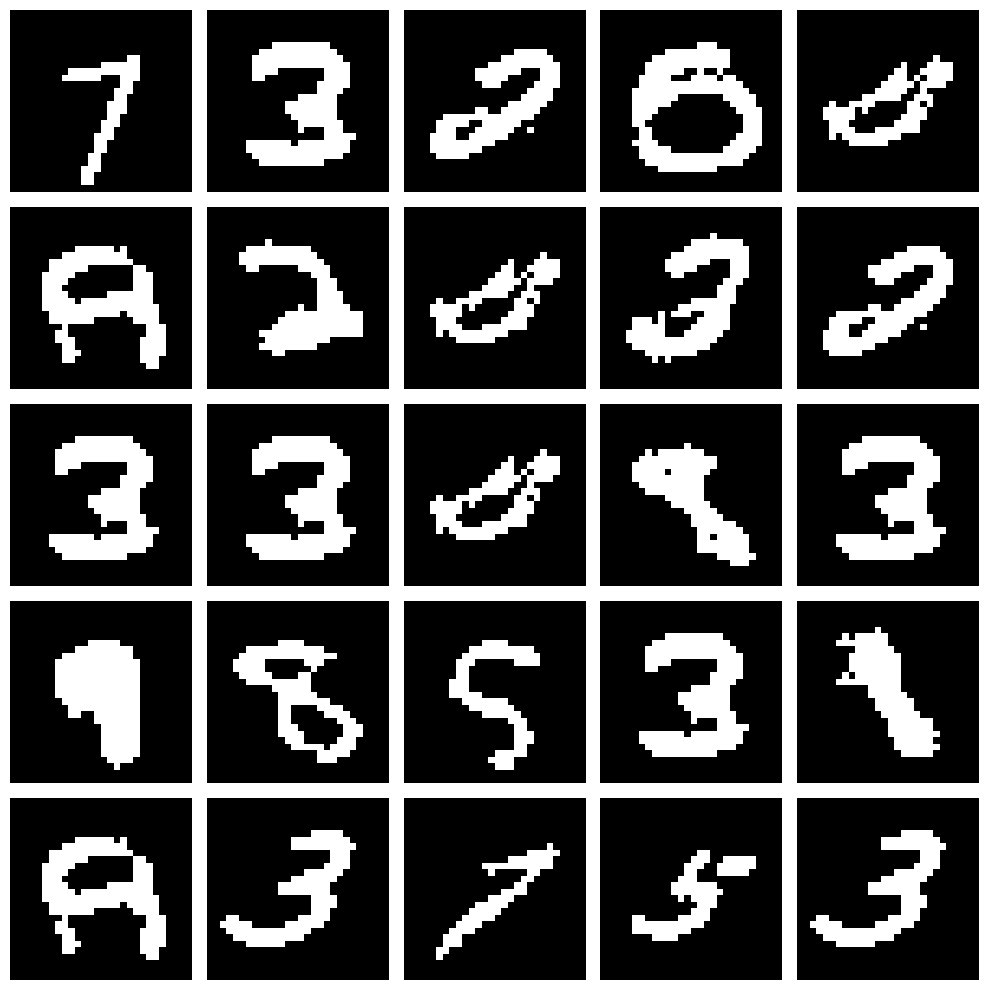

In [13]:
# Visualise the generated images
plot_digits(X=generated_images, Y=None, n=25)

_____________

# THANK YOU 
_____________